In [1]:
# Disable GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling

from bokeh.plotting import output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
%cd ..

D:\anomaly-detection


## Импорт данных

In [3]:
data = pd.read_csv('data/processed/tep_data.csv', index_col='Index')
print(f'Len of dataset: {data.shape[0]}')

Len of dataset: 12801


In [4]:
component = 3
X_one_component = data[str(component)]

In [5]:
train_ratio = 0.6
train_len = int(X_one_component.shape[0] * train_ratio)
X_tr = X_one_component[train_len:]
X_val = X_one_component[train_len:]

In [6]:
from src.features.build_features import rolling_window
window_length = 64

X_tr_windows = rolling_window(pd.DataFrame(X_tr), window_length).squeeze()
X_val_windows = rolling_window(pd.DataFrame(X_val), window_length).squeeze()

## Гиперпараметры модели

In [7]:
from src.models.autoencoder import build_autoencoder
import keras

create_params = dict(
    input_shape=window_length,
    hidden_layer_size=16,
    hidden_layer_activation=None,
    reg_strength=0.001,
    input_dropout=-1,
)

compile_params = dict(
    optimizer=keras.optimizers.Adam(lr=0.001),
    loss='mse',
)

fit_params = dict(
    batch_size=64,
    epochs=100,
    verbose=1,
    callbacks=[keras.callbacks.ReduceLROnPlateau(patience=5),
               keras.callbacks.EarlyStopping(min_delta=0.01, patience=15)]
)

model_fn = lambda: build_autoencoder(create_params, compile_params)

Using TensorFlow backend.


## Обучение модели

### Кросс-валидация

In [20]:
from src.utils import cross_validate

X_comp = rolling_window(X_one_component.to_numpy()[:, None], window_length=window_length).squeeze()

results = cross_validate(model_fn, 3, fit_params, X_comp, X_comp)

Fold 0...


Train on 3185 samples, validate on 3184 samples
Epoch 1/100
3185/3185 [==============================] - 1s 210us/step - loss: 1.0796 - val_loss: 0.6876
Epoch 2/100
3185/3185 [==============================] - 0s 41us/step - loss: 0.3806 - val_loss: 0.2924
Epoch 3/100
3185/3185 [==============================] - 0s 38us/step - loss: 0.2524 - val_loss: 0.2509
Epoch 4/100
3185/3185 [==============================] - 0s 24us/step - loss: 0.2305 - val_loss: 0.2321
Epoch 5/100
3185/3185 [==============================] - 0s 26us/step - loss: 0.2149 - val_loss: 0.2164
Epoch 6/100
3185/3185 [==============================] - 0s 25us/step - loss: 0.2015 - val_loss: 0.2031
Epoch 7/100
3185/3185 [==============================] - 0s 24us/step - loss: 0.1902 - val_loss: 0.1911
Epoch 8/100
3185/3185 [==============================] - 0s 29us/step - loss: 0.1801 - val_loss: 0.1811
Epoch 9/100
3185/3185 [==============================] - 0s 31us/step - loss: 0.1717 - val_loss: 0.1725
Epo

9553/9553 [==============================] - 0s 14us/step - loss: 0.1169 - val_loss: 0.1181
Epoch 19/100
9553/9553 [==============================] - 0s 14us/step - loss: 0.1168 - val_loss: 0.1179


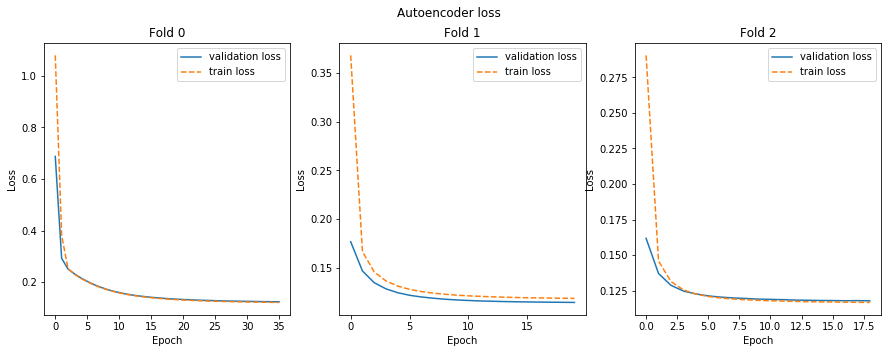

In [21]:
from src.visualization.visualize import visualize_cv_result
visualize_cv_result(results, f'Autoencoder loss')

### Train/validation

In [10]:
model = model_fn()
model.fit(
    X_tr_windows,
    X_tr_windows,
    validation_data=(X_val_windows, X_val_windows),
    batch_size=64,
    epochs=100,
    verbose=1,
)







Train on 5057 samples, validate on 5057 samples
Epoch 1/100
5057/5057 [==============================] - 1s 139us/step - loss: 0.5819 - val_loss: 0.2633
Epoch 2/100
5057/5057 [==============================] - 0s 38us/step - loss: 0.2344 - val_loss: 0.2166
Epoch 3/100
5057/5057 [==============================] - 0s 39us/step - loss: 0.2054 - val_loss: 0.1940
Epoch 4/100
5057/5057 [==============================] - 0s 37us/step - loss: 0.1853 - val_loss: 0.1764
Epoch 5/100
5057/5057 [==============================] - 0s 24us/step - loss: 0.1696 - val_loss: 0.1629
Epoch 6/100
5057/5057 [==============================] - 0s 23us/step - loss: 0.1588 - val_loss: 0.1526
Epoch 7/100
5057/5057 [==============================] - 0s 22us/step - loss: 0.1490 - val_loss: 0.1452
Epoch 8/100
5057/5057 [==============================] - 0s 24us/step - loss: 0.1423 - val_loss: 0.1396
Epoch 9/100
5057/5057 [==============================] - 0s 25us/step - loss: 0.1374 - val_loss: 0.1352
Epoch 10/

In [11]:
model.save('models/onedimensional_autoencoder.h5')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1088      
Total params: 2,128
Trainable params: 2,128
Non-trainable params: 0
_________________________________________________________________


## Извлечём слой, который "эмбеддит"

In [26]:
import keras
from keras.layers import Input
from keras.models import Model, load_model

model = load_model('models/onedimensional_autoencoder.h5')

inp = Input(shape=(window_length,))
encoder_layer = model.layers[0]
encoded = encoder_layer(inp)

encoder = Model(inputs=inp, outputs=encoded)

## Добавим аномалии в нормальные данные

In [22]:
from src.data.generate import generate_anomalies
data_with_anom = data[str(component)].copy()
anom_amount = 100
anom_idxs_start = np.random.choice(len(data_with_anom),
                                   anom_amount,
                                   replace=False)
anom_lens = np.zeros(anom_amount, dtype=int)
anom_idxs = np.zeros(len(data_with_anom), dtype=int)

for i, idx in enumerate(anom_idxs_start):
    l = np.random.randint(window_length, window_length * 2)

    if idx + l > data_with_anom.shape[0]:
        raise Exception('Try again, index out of range (FIXME THEN)')

    anom_lens[i] = l
    anoms = generate_anomalies(l)
    anom_idxs[idx:idx + l] = 1
    data_with_anom[idx:idx + l] = anoms[np.random.randint(len(anoms))]

In [23]:
X_anom = rolling_window(pd.DataFrame(data_with_anom), window_length).squeeze()

## Кластеризация эмбеддингов

### KMeans

In [27]:
encoded = encoder.predict(X_anom)

Найдём оптимальное значение количества кластеров по *elbow*

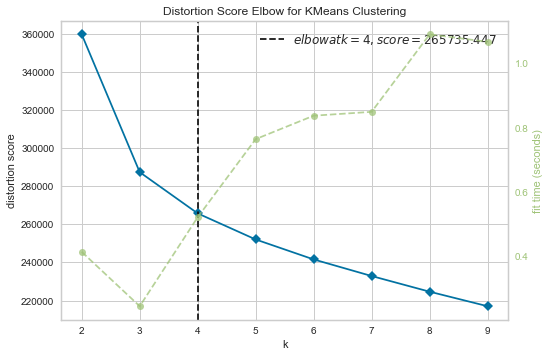

In [28]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,10), metric='distortion')
visualizer.fit(encoded)
visualizer.poof()

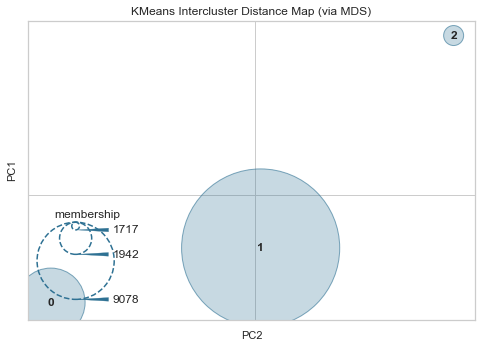

In [29]:
from yellowbrick.cluster import InterclusterDistance

km = KMeans(3)
intra_visualizer = InterclusterDistance(km)

intra_visualizer.fit(encoded)        # Fit the data to the visualizer
intra_visualizer.poof()        # Draw/show/poof the data

Будем считать, что `0-ой` и `2-ой` кластеры полностью аномальные (выбрали наименьшие кластеры)

In [33]:
pred = km.predict(encoded)
maximal_cluster = pd.Series(pred).value_counts().idxmax()
anoms_pred = np.where(pred != maximal_cluster)[0]

In [30]:
# pred = km.predict(encoded)
# minimal_cluster = pd.Series(pred).value_counts().idxmin()
# anoms_pred = np.where(pred == minimal_cluster)[0]

In [35]:
from sklearn.metrics import recall_score, precision_score
from src.utils import intersection_over_true

recall = intersection_over_true(data.shape[0], anom_idxs_start, anom_lens, anoms_pred, window_length, recall_score)
precision = intersection_over_true(data.shape[0], anom_idxs_start, anom_lens, anoms_pred, window_length, precision_score)
print(f'Полнота={recall:.3f}, Точность={precision:.3f}')

Полнота=0.216, Точность=0.240


In [ ]:
from bokeh.plotting import figure, show
from src.utils import *

p = figure(plot_width=800,
           plot_height=600,
           tools="xwheel_zoom,pan,box_zoom,reset")

p.multi_line(
    [
        list(range(data_with_anom.shape[0])),
        *[list(range(idx, idx + l)) for idx, l in zip(anom_idxs_start, anom_lens)],
        *[list(range(idx, idx + window_length)) for idx in anoms_pred],
    ],
    [
        data_with_anom,
        *[
            data_with_anom.iloc[idx:idx + l]
            for idx, l in zip(anom_idxs_start, anom_lens)
        ],
        *[data_with_anom.iloc[idx:idx + window_length] for idx in anoms_pred],
    ],
    color=["green", *['red'] * len(anom_idxs_start), *['blue'] * len(anoms_pred)],
    alpha=[0.6, *[0.5] * len(anom_idxs_start), *[0.5] * len(anoms_pred)],
    line_width=4,
    legend=f'Recall={recall:.3f}, Precision={precision:.3f}',
)

In [37]:
# Blue - anomalies predicted by model
# Red - anomalies that was not catched by model
# Green - original data, that is neither anomaly nor predicted as anomaly

show(p)